In [53]:
import json
import numpy as np
import matplotlib.pyplot as plt
import re
from matplotlib.colors import LogNorm
import copy
import tqdm
import string

import sys
sys.path.append("../src")

import hessian
import system
import utils

In [2]:
all_coords = hessian.get_modes("../data/hessians/opt_truncated.molden", 231, 79)

# Single (truncated) BChla

In [3]:
wavenumbers = hessian.get_wavenumbers("../data/hessians/opt_truncated.molden")
frequencies = hessian.wavenumber_to_frequency(wavenumbers)

In [24]:
targets = np.array([670.674752, 727.409421, 1166.792831, 1185.698076, 1220.518895, 1323.725675, 1538.307155])

hrf_modes = []

for enum, i in enumerate(wavenumbers):
    check = np.where(np.abs(targets - i) < 1)

    if len(check[0]) > 0:
        print(enum, i, targets[check[0]])
        
        hrf_modes.append(enum)
    
    

76 670.674752 [670.674752]
80 727.409421 [727.409421]
129 1166.792831 [1166.792831]
131 1185.698076 [1185.698076]
136 1220.518895 [1220.518895]
149 1323.725675 [1323.725675]
188 1538.307155 [1538.307155]


In [4]:
CO = [enum for enum, x in enumerate(wavenumbers) if x > 1600 and x < 1800]
CO

[191, 192, 193, 194]

In [5]:
print(wavenumbers[CO[1:]])

[1724.408186 1774.418953 1797.554929]


In [6]:
all_coords[:,:, CO[1]]

array([[-1.54000e-04,  1.85000e-04, -3.90000e-05],
       [-1.35500e-03,  1.19600e-03,  1.01000e-04],
       [ 3.74200e-03,  3.85900e-03, -1.95000e-04],
       [ 2.78000e-03, -1.66200e-03,  3.08000e-04],
       [ 1.48500e-03,  1.97100e-03,  6.50000e-05],
       [-3.86000e-04,  3.93000e-04, -2.10000e-05],
       [ 7.14000e-04, -8.77000e-04, -8.50000e-05],
       [-1.60000e-04,  1.18000e-04,  2.70000e-05],
       [ 9.40000e-05,  1.31000e-04,  1.50000e-05],
       [-5.06000e-04, -2.70400e-03,  2.41000e-04],
       [-2.00000e-06, -4.30000e-05,  5.80000e-05],
       [ 5.00000e-06, -3.00000e-06, -5.80000e-05],
       [ 1.50000e-05,  2.40000e-05,  4.80000e-05],
       [-1.70800e-03, -1.59900e-03,  3.50000e-04],
       [-3.10700e-03, -8.93000e-03, -2.29000e-04],
       [ 1.13130e-02,  8.77000e-03,  6.48000e-04],
       [ 5.80100e-03, -5.60000e-04,  1.86400e-03],
       [-7.77300e-03,  5.21800e-03, -1.48400e-03],
       [-1.21800e-03,  3.70000e-05, -2.27000e-04],
       [-2.15195e-01,  4.37000e

In [7]:
all_displacements = np.linalg.norm(all_coords, axis=1)
all_displacements.shape

(79, 231)

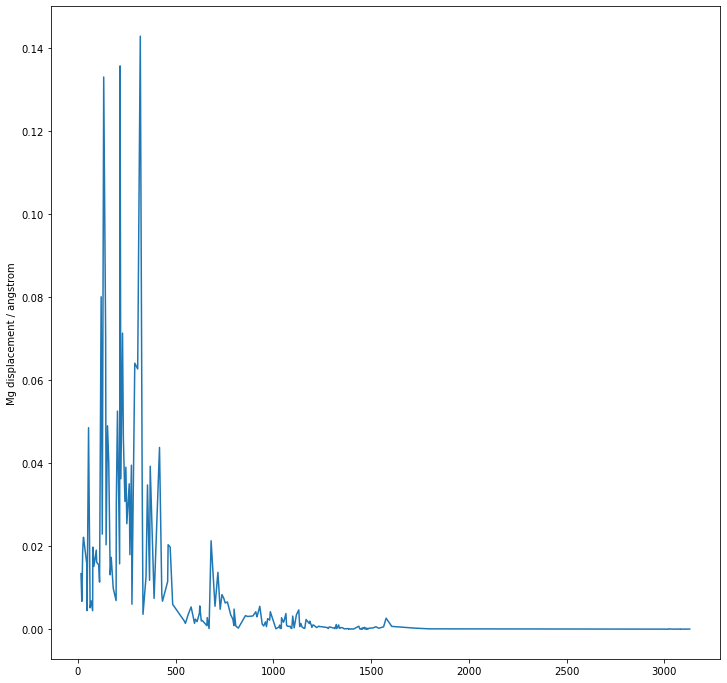

In [8]:
fig, ax = plt.subplots()

n_atoms = 79
n_modes = 3 * n_atoms - 6

Mg_index = 0

ax.plot(wavenumbers, all_displacements[Mg_index])

ax.set_ylabel("Mg displacement / angstrom")

fig.set_size_inches(12,12)

plt.savefig("../images/mg_displacement.png")

79
(79, 231)


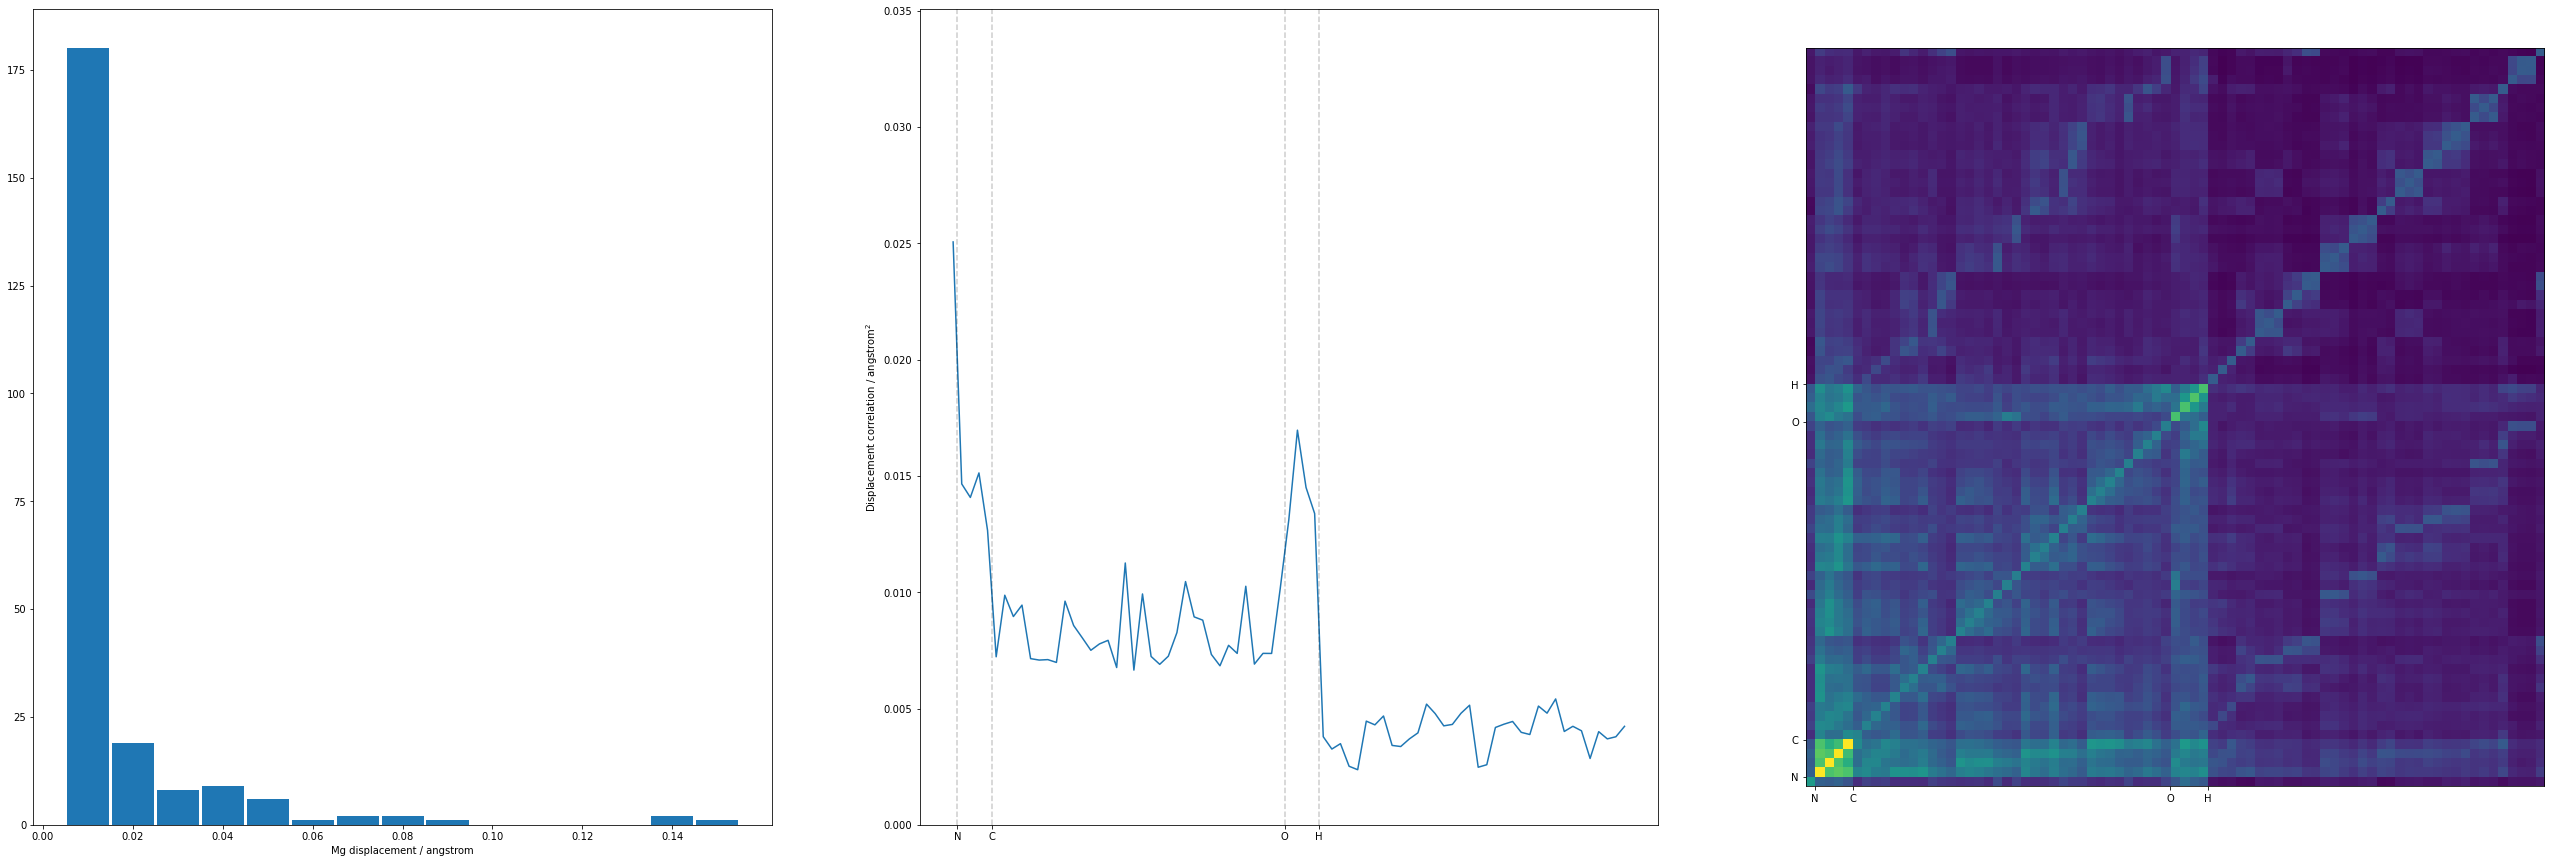

In [9]:
fig, ax = plt.subplots(1, 3)

symbols = system.read_symbols("../data/hessians/opt_truncated.xyz")

print(len(symbols))

Mg_indices= utils.get_indices(symbols, "Mg")
N_indices = utils.get_indices(symbols, "N")
C_indices = utils.get_indices(symbols, "C")
O_indices = utils.get_indices(symbols, "O")
H_indices = utils.get_indices(symbols, "H")

Mg_max_disp= all_displacements[Mg_indices].max()
N_max_disp = all_displacements[N_indices].max()
C_max_disp = all_displacements[C_indices].max()
O_max_disp = all_displacements[O_indices].max()
H_max_disp = all_displacements[H_indices].max()

print(all_displacements.shape)

normalized_displacements = copy.copy(all_displacements)

normalized_displacements[Mg_indices]/= Mg_max_disp
normalized_displacements[N_indices] /= N_max_disp
normalized_displacements[C_indices] /= C_max_disp
normalized_displacements[O_indices] /= O_max_disp
normalized_displacements[H_indices] /= H_max_disp

grouped_symbols = np.concatenate((Mg_indices, N_indices, C_indices, O_indices, H_indices))

normalized_displacements = normalized_displacements[grouped_symbols]

bins = np.linspace(0, 0.15, 16)
his = np.histogram(all_displacements[Mg_index], bins=bins)

ax[0].bar(his[1][1:], his[0], width=0.15/len(bins), align='center')
ax[0].set_xticks(bins[::2])

ax[0].set_xlabel("Mg displacement / angstrom")
ax[1].set_ylabel("Frequency")

Mg_displacements = np.where(all_displacements[Mg_index] > 0.0)[0]

correlation = np.zeros((n_atoms, n_atoms))

for i in Mg_displacements:
    correlation += np.outer(normalized_displacements[:,i], normalized_displacements[:,i])
    
correlation /= len(Mg_displacements)

cax = ax[2].imshow(correlation, origin='lower', cmap=plt.get_cmap('viridis'))#, norm=LogNorm(vmin=0.0001, vmax=20))
    
#fig.colorbar(cax)

def ticks(symbols):
    Mg_indices= utils.get_indices(symbols, "Mg")
    N_indices = utils.get_indices(symbols, "N")
    C_indices = utils.get_indices(symbols, "C")
    O_indices = utils.get_indices(symbols, "O")
    H_indices = utils.get_indices(symbols, "H")
    
    lengths = [len(Mg_indices), len(N_indices), len(C_indices), len(O_indices), len(H_indices)]
    
    cumulative = np.cumsum(lengths)
    
    ticks = np.array([x - 0.5 for x in cumulative[:-1]])
    
    return ticks

# number of each element --  Mg: 1, N: 4, C: 55, O: 6, H: 74
# cumulative -- 1, 5, 39, 43, 79

symbol_ticks = ticks(symbols)
symbol_labels= ["N","C","O","H"]

ax[2].set_xticks(symbol_ticks)
ax[2].set_xticklabels(symbol_labels)

ax[2].set_yticks(symbol_ticks)
ax[2].set_yticklabels(symbol_labels)

ax[1].plot(correlation[0])
ax[1].set_xticks(symbol_ticks)
ax[1].set_xticklabels(symbol_labels)
ax[1].set_ylabel("Displacement correlation / $\mathrm{angstrom}^2$")

ax[1].vlines(symbol_ticks, color='black', linestyle='--', ymin=0, ymax=max(correlation[0])+0.01, alpha=0.2)
ax[1].set_ylim(0, max(correlation[0])+0.01)

fig.set_size_inches(45,15)

plt.savefig("../images/mg_correlations.png")

670.674752
727.409421
1166.792831
1185.698076
1220.518895
1323.725675
1538.307155


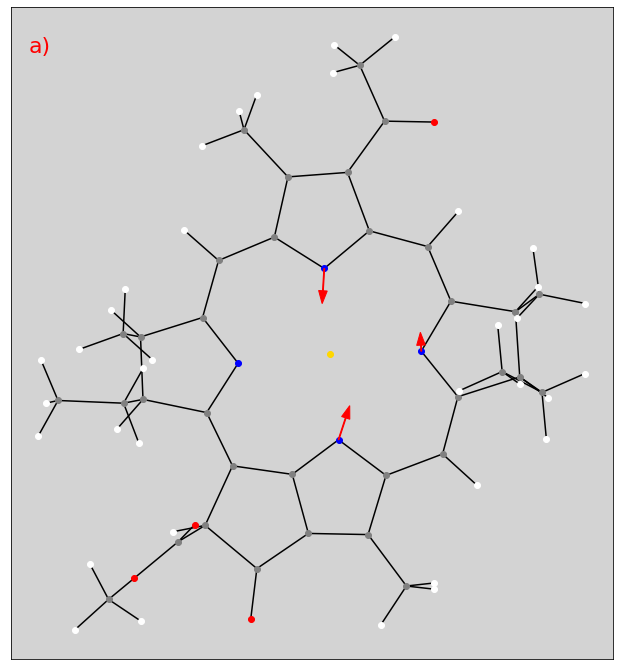

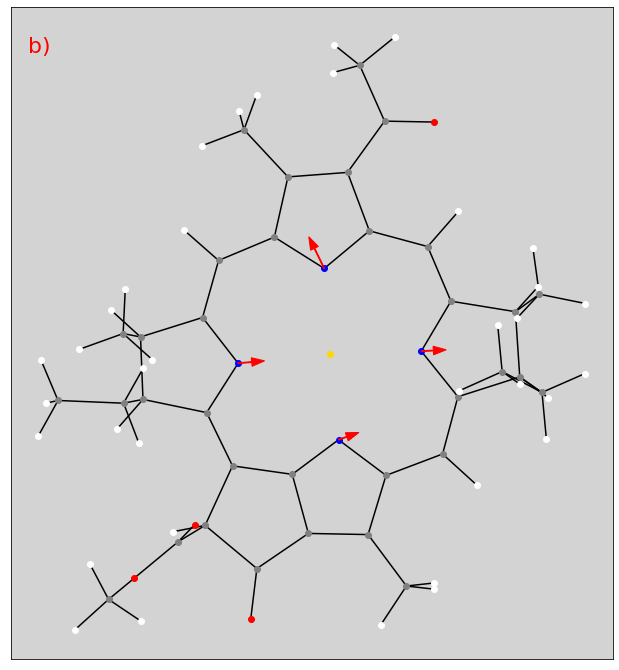

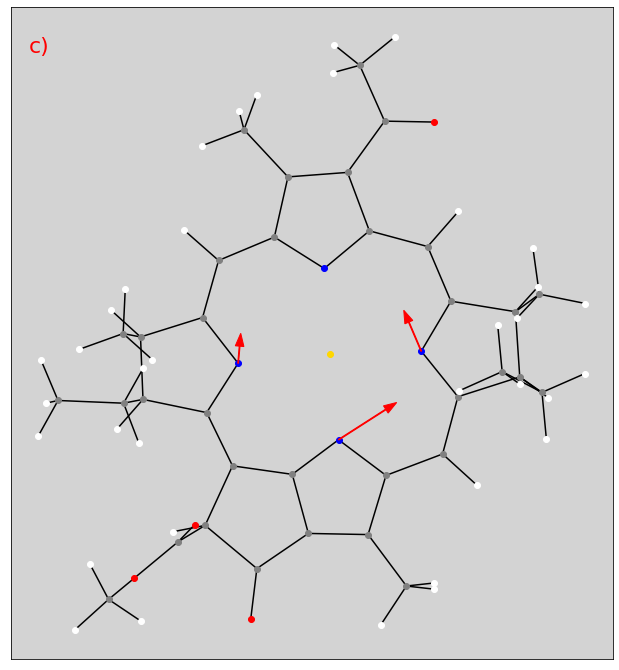

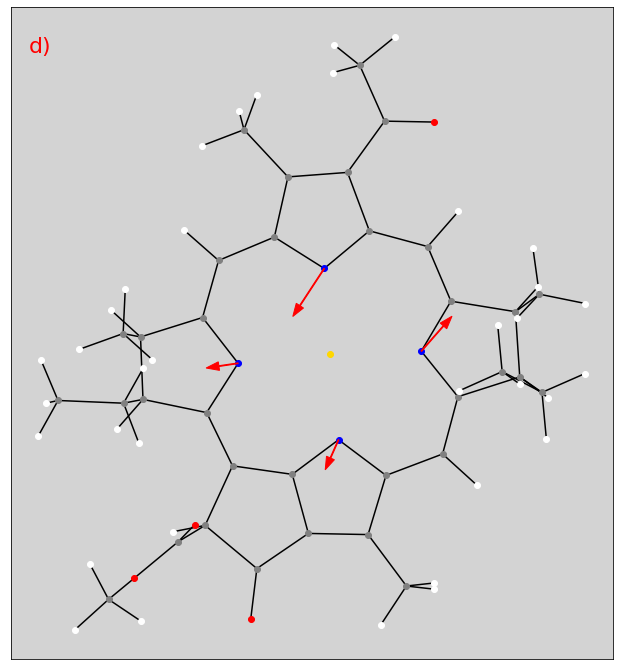

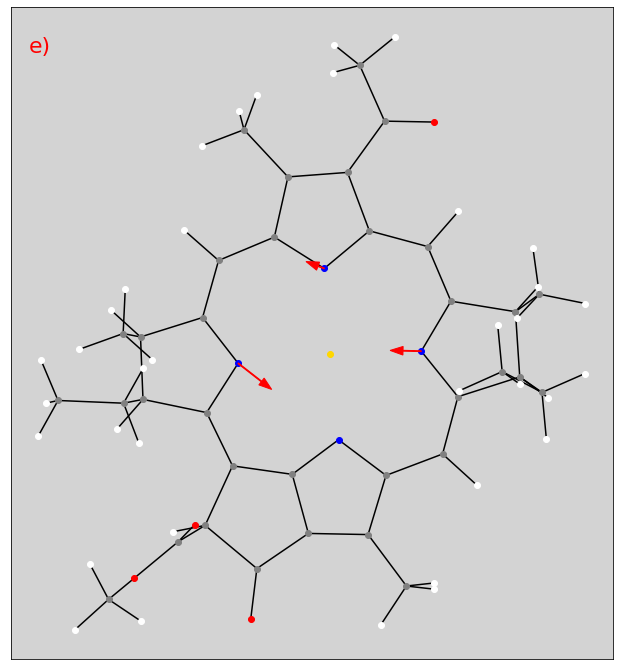

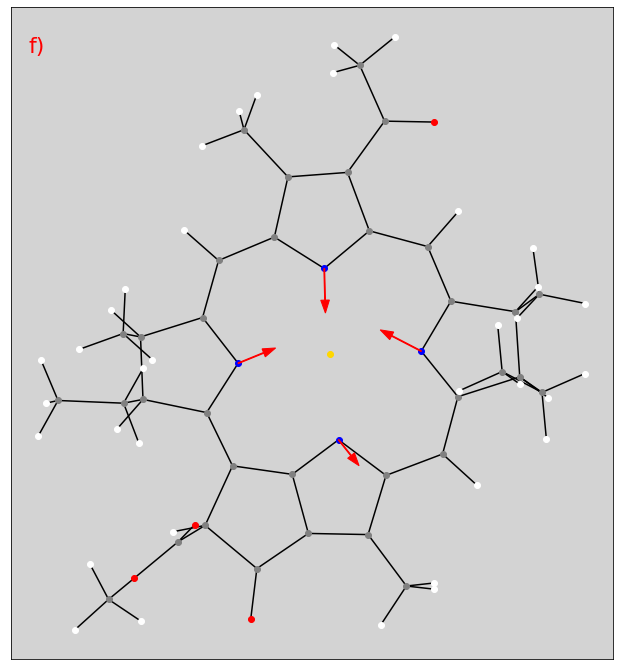

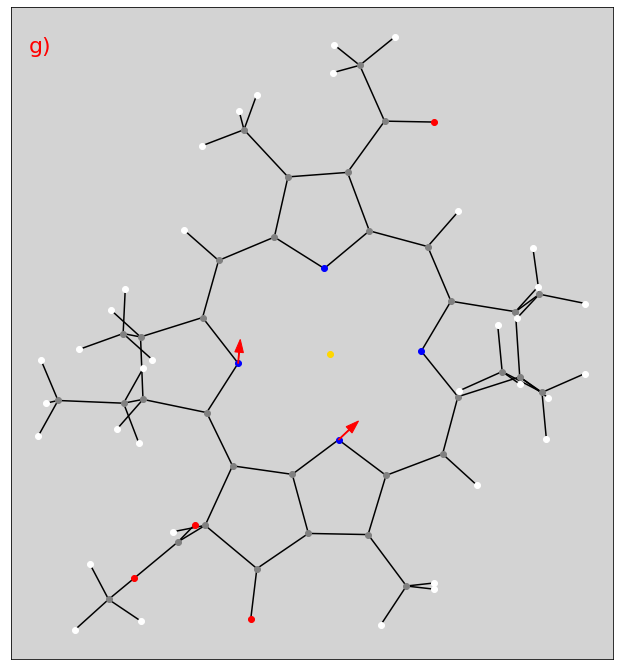

In [66]:
symbols = system.read_symbols("../data/hessians/opt_truncated.xyz")

bchla_in_xy_plane, rotation_matrix = system.get_bchla_in_xy_plane("../data/hessians/opt_truncated.xyz")

ms = hrf_modes #[CO[1]]

scl = 15

for enum, m in enumerate(ms):
    fig, ax = plt.subplots()

    system.plot_molecule(bchla_in_xy_plane, symbols, ax)
    
    print(wavenumbers[m])
    mode = all_displacements[:, m]    
    for n in range(n_atoms):

        #ax.annotate(n, (bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1]))

        #if n not in [5, 9, 2, 14, 13, 17, 3, 23, 22, 26, 4, 31, 30, 34, 1, 6]:
        if n not in [5, 13, 22, 30]:
            continue
        
        if mode[n] > 1e-2:
            #circle = plt.Circle((bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1]), 2*mode[n], color='red', alpha=0.2, zorder=0)
            #ax.add_patch(circle)

            disp_vec = np.matmul(rotation_matrix, np.array([all_coords[n][0][m], all_coords[n][1][m], all_coords[n][2][m]]))
                        
            ax.arrow(bchla_in_xy_plane[n][0], bchla_in_xy_plane[n][1], scl * disp_vec[0], scl * disp_vec[1], head_width=0.2, width=0.02, color='red')
        
    ax.annotate(f"{string.ascii_lowercase[enum]})", (-7,7), color='red', size=22)

    ax.set_yticks([])
    ax.set_xticks([])
        
    fig.set_size_inches(12,12)

    plt.savefig(f"../images/vibration_{m}.png")

In [9]:
1/hessian.wavenumber_to_frequency(1600)

20.8477559498845

In [10]:
normalized_displacements[:, 192]

array([1.70649289e-03, 3.87835076e-03, 1.66438010e-02, 7.38123081e-03,
       3.31158156e-03, 8.04020723e-03, 2.38916147e-02, 1.44513559e-02,
       1.09651440e-02, 5.03730859e-03, 8.91152177e-04, 7.19259575e-04,
       1.22657340e-02, 3.20821278e-04, 2.58919305e-04, 2.47504756e-04,
       4.20092411e-02, 6.36450982e-02, 2.71780885e-02, 4.21027164e-02,
       5.50564246e-03, 1.00000000e+00, 5.31490357e-02, 2.63639391e-03,
       9.02503490e-04, 9.43385419e-04, 1.05420925e-02, 5.51276527e-04,
       6.87494079e-04, 3.52019841e-04, 8.08845986e-03, 5.38805833e-03,
       3.84093329e-03, 7.26369983e-03, 3.24368399e-04, 1.82445955e-02,
       3.58929651e-04, 4.15271202e-03, 2.61232993e-04, 1.00000000e+00,
       1.79920518e-02, 3.47971272e-03, 1.68718278e-03, 5.31271814e-03,
       2.22772551e-02, 1.31679844e-03, 2.83172215e-04, 6.94267618e-04,
       3.45163861e-04, 3.82383068e-04, 1.12628387e-04, 1.81577837e-04,
       1.57081282e-04, 2.23317307e-04, 2.71475798e-04, 6.61900339e-03,
      